In [84]:
%load_ext autoreload
%autoreload 2
import torch
import torch.utils.data
import numpy as np
import sklearn.datasets
import sklearn.model_selection
import matplotlib.pyplot as plt

import abstract_gradient_training as agt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
"""Initialise the halfmoons training data."""
seed = 0
batchsize = 10000  # number of samples per batch
test_size = 5000
n_users = 250
n_batches = 1  # number of batches per epoch
n_epochs = 10  # number of epochs

torch.manual_seed(seed)
# load the dataset
x, y = sklearn.datasets.make_moons(noise=0.1, n_samples=n_batches*batchsize + test_size, random_state=seed)
# to make it easier to train, we'll space the moons out a bit and add some polynomial features
x[y==0, 1] += 0.2
x = np.hstack((x, x**2, (x[:, 0] * x[:, 1])[:, None], x**3))


# Train-test split
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=test_size / (n_batches * batchsize + test_size), random_state=seed
)


# Assign users randomly to each set after the split
user_train = np.random.randint(1, n_users + 1, size=len(x_train))
user_test = np.random.randint(1, n_users + 1, size=len(x_test))

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)
user_train = torch.from_numpy(user_train)
user_test = torch.from_numpy(user_test)

# Combine inputs and both labels into TensorDatasets
dataset_train = torch.utils.data.TensorDataset(x_train, user_train, y_train)
dataset_test = torch.utils.data.TensorDataset(x_test, user_test, y_test)

print(y)

# Create DataLoaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)



[0 1 1 ... 1 1 0]


In [86]:
privacy_bounded_models = {}
k_private_values = [1, 2, 5, 10, 20, 50, 100] 
for k in k_private_values:
    model = torch.nn.Sequential(
        torch.nn.Linear(7, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 2),
    )
    bounded_model = agt.bounded_models.IntervalBoundedModel(model, trainable=True)
    bounded_model.load_params(f"model_user_10000/250/k_{k}.model")
    privacy_bounded_models[k] = bounded_model

# evaluate the fine-tuned model
dataset_test_all = torch.utils.data.TensorDataset(x_test, y_test)
accuracy = agt.test_metrics.test_accuracy(bounded_model, *dataset_test_all.tensors)
print(f"Fine-tuned model accuracy + certified bounds (all classes): {accuracy[0]:.2f} <= {accuracy[1]:.2f} <= {accuracy[2]:.2f}")

Fine-tuned model accuracy + certified bounds (all classes): 0.00 <= 0.77 <= 1.00


In [87]:
# make privacy-safe predictions using the global sensitivity
epsilon = 1.0
# dataset_test_all = dataset_test
accuracy = agt.privacy_utils.noisy_test_accuracy(
    bounded_model, *dataset_test_all.tensors, noise_level=1 / epsilon, noise_type="laplace"
)
print(f"Accuracy using global sensitivity: {accuracy:.2f}")

# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = agt.privacy_utils.get_calibrated_noise_level(
    dataset_test_all.tensors[0], privacy_bounded_models, epsilon=epsilon, noise_type="cauchy" 
)
accuracy = agt.privacy_utils.noisy_test_accuracy(
    bounded_model, *dataset_test_all.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

Accuracy using global sensitivity: 0.59
Accuracy using AGT smooth sensitivity bounds: 0.55


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

dataset_test = torch.utils.data.TensorDataset(x_test, y_test)

# Define the specific epsilon values
# epsilon_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000, 100000000000, 1000000000000]

epsilon_values = [0.001,
                0.004,
                0.016,
                0.064,
                0.128,
                0.256,
                0.512,
                1.024,
                2.048,
                4.096,
                8.192,
                16.384,
                32.768,
                65.536,
                262.144,
                1048.576,
                4194.304,
                16777.216,
                67108.864]

# Store results for both normal MSE and global sensitivity-based MSE
normal_mse_values = []
global_sensitivity_mse_values = []
no_privacy_mse_values = []

# Loop over epsilon values and calculate the MSE for each
for epsilon in epsilon_values:
    print(epsilon)
    # Calculate the noise level using AGT smooth sensitivity bounds
    noise_level = agt.privacy_utils.get_calibrated_noise_level(
        dataset_test.tensors[0], privacy_bounded_models, epsilon=epsilon, noise_type="cauchy"
    )
    print(noise_level)
    
    ave = 0
    num = 1000
    for i in range(num):
        ave += agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=noise_level, noise_type="cauchy"
        )
    acc = ave / (num)
    print(acc)
    # print(f"Average MSE is {ave / (num * len(dataset_test))}")
    
    # Store normal MSE
    normal_mse_values.append(acc)
    

    ave = 0
    num = 1000
    for i in range(num):
        ave += agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=6/epsilon, noise_type="cauchy"
        )
    
    acc = ave / (num)
    # Store global sensitivity MSE
    global_sensitivity_mse_values.append(acc)

    no_privacy_mse = agt.privacy_utils.noisy_test_accuracy(
            privacy_bounded_models[100], *dataset_test.tensors, noise_level=0, noise_type="none"
        ) 

    # no_privacy_mse = agt.test_metrics.test_accuracy(privacy_bounded_models[1], x_test, y_test)[1]
    # Store global sensitivity MSE
    no_privacy_mse_values.append(no_privacy_mse)



0.001
tensor([5998.0010, 5995.0054, 5995.0054,  ..., 5990.0142, 5995.0054,
        5995.0054], device='cuda:0')
0.4999740879386663
2
0.004
tensor([1498.0016, 1495.0090, 1495.0090,  ..., 1490.0347, 1495.0090,
        1495.0090], device='cuda:0')
0.5000091879963875
2
0.016
tensor([373.0054, 370.0334, 370.0334,  ..., 365.1325, 370.0334, 370.0334],
       device='cuda:0')
0.5003434883654118
2
0.064
tensor([91.7712, 88.8810, 88.8810,  ..., 84.2649, 88.8810, 88.8810],
       device='cuda:0')
0.5010458882153034
2
0.128
tensor([44.9171, 42.1325, 42.1325,  ..., 37.8697, 42.1325, 42.1325],
       device='cuda:0')
0.5019316882938146
2
0.256
tensor([21.5205, 18.9349, 18.9349,  ..., 15.2972, 18.9349, 18.9349],
       device='cuda:0')
0.5048476883322001
2
0.512
tensor([9.8801, 7.6486, 7.6486,  ..., 4.9921, 7.6486, 7.6486], device='cuda:0')
0.512245587155223
2
1.024
tensor([4.1650, 2.4961, 2.4961,  ..., 1.0633, 2.4961, 2.4961], device='cuda:0')
0.5399518865942955
2
2.048
tensor([1.4803, 0.5316, 0.531

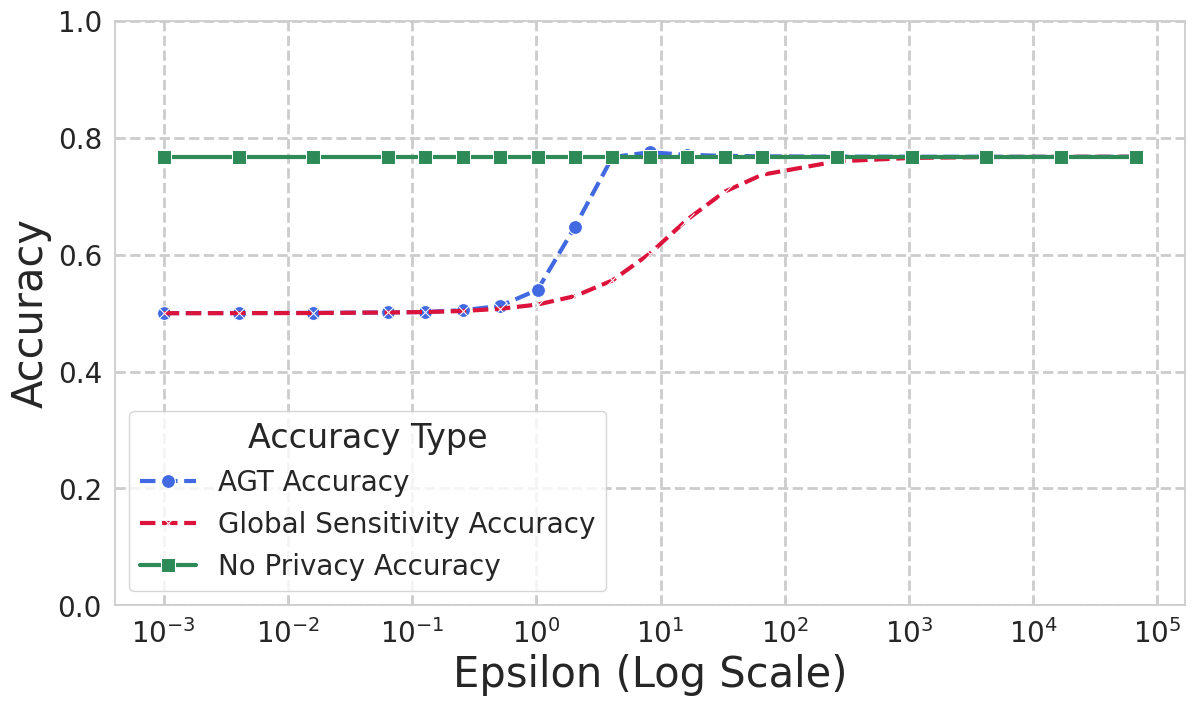

In [89]:
import seaborn as sns
# Apply a Seaborn theme
# sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 7))

# Plot MSE curves with enhanced styles
sns.lineplot(x=epsilon_values, y=normal_mse_values, label="AGT Accuracy", 
             marker='o', markersize=10, linestyle='--', color='royalblue', linewidth=3)

sns.lineplot(x=epsilon_values, y=global_sensitivity_mse_values, label="Global Sensitivity Accuracy", 
             marker='x', markersize=10, linestyle='--', color='crimson', linewidth=3)

sns.lineplot(x=epsilon_values, y=no_privacy_mse_values, label="No Privacy Accuracy", 
             marker='s', markersize=10, linestyle='-', color='seagreen', linewidth=3)

# sns.lineplot(x=epsilon_values, y=no_privacy_mse_values, label="Laplace Global", 
#              marker='s', markersize=10, linestyle='-', color='black', linewidth=3)


# Log scale for both axes
plt.xscale('log')
# plt.yscale('log')

# Axis labels and title
plt.xlabel('Epsilon (Log Scale)', fontsize=30)
plt.ylabel('Accuracy', fontsize=30)
# plt.title('MSE vs Epsilon under Different Privacy Settings', fontsize=16, fontweight='bold')

# Legend and grid
plt.legend(title='Accuracy Type', fontsize=20, title_fontsize=24, loc='best')
plt.grid(True, which="both", linestyle='--', linewidth=2)

# Tidy up layout
plt.tight_layout()

plt.ylim(0, 1)

plt.tick_params(axis='both', labelsize=20) 

plt.grid(which='minor', visible=False) 
# Show plot
plt.show()